# Behaviour of the weighted generalized mean model of concurrency 
In this notebook the generalized mean model of concurrency is introduced and its behaviour is analized on a simple case.

A theano-based implementation of the gradient-descent algorithm is presented and its behaviour is analyzed perturbing individual model parameters near the global minimum. 

In [ ]:
%matplotlib inline

In [2]:
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np

# The weighted generalized mean model

$$
M(\mathbf{x}, \mathbf{w}, p) =  
 \left\{
  \begin{array}{cl}
	\left(\sum_{i=1}^n w_i x_i^p \right)^{\frac{1}{p}}
 	& \texttt{if } p \neq 0 \\
 	\prod_{i=1}^n x_i^{w_i}
 	& \texttt{if } p=0 \\
  \end{array}
 \right.
$$

$$
RT(\mathbf{x}, \mathbf{w}, p, \mu,\sigma) = M(\mathbf{x}, \mathbf{w}, p)  + \exp({\mathcal{N}(\mu,\,\sigma^{2})\,})
$$

$$
\mathbf{x} = \exp({\mathcal{N}(...,\,...)\,})
$$


## Analyse the behaviour of the generalized mean
We fix $n=2$, $w=[1, 1]$ and $x_0=1$ and plot $M$ as a function of $x_1$ for different values of $p$.

In [3]:
def plotM(fro, to, N, p_values):
    n=2
    w=np.ones(n)/n
    curves = list()
    for p in p_values:
        #print p
        x_0=np.ones(N)
        x_1 = np.linspace(fro, to, N)
        X = np.stack([x_0, x_1], axis=1)
        M = np.power(np.dot(np.power(X, p), w), 1.0/p)
        curves.append((x_1, M))
        
    plt.figure(figsize=(10, 10))
    plt.grid()
    plt.title('Generalized mean, x_0=1')
    plt.xlabel('x_1')
    plt.ylabel('M')
    #plt.yscale('log')
    colors = cm.rainbow(np.linspace(0, 1, len(curves)))
    handles = list()
    for color, curve, p in zip(colors, curves, p_values):
        label = "p={:5.2f}".format(p)
        h1 = plt.plot(*curve, linestyle='-', c=color, alpha=1, label=label)
        h2= plt.scatter(*curve, linestyle='--', c=color, alpha=0.9, label=label)
        handles.append((h1[0], label))
    plt.legend(*zip(*handles), loc='best')
    plt.xlim((fro, to))
    plt.ylim((fro, to))
    plt.show()

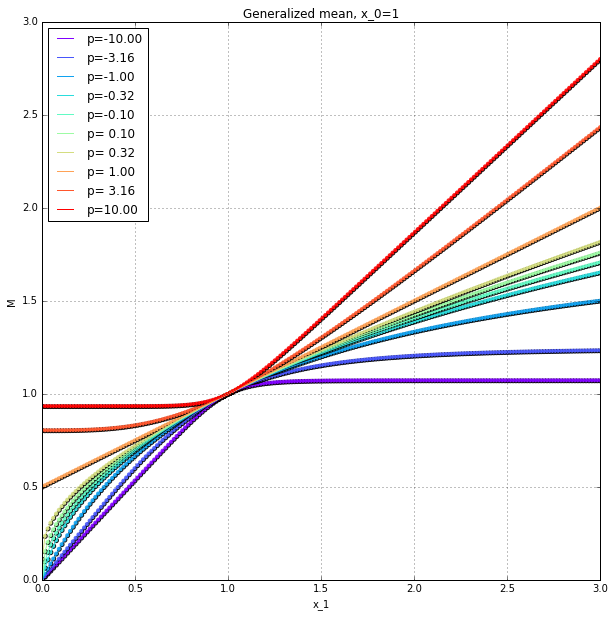

In [4]:
plotM(0, 3, 200, sorted(np.hstack([np.logspace(-1, 1, 5), -np.logspace(-1, 1, 5)])))

minel kisebb p, annal meredekebb

## Synthetize data with the weighted generalized mean

In [5]:
def sample(locX, scaleX, w, p, mu, sigma, N, ):
    """ @param locX: location parameters of log-norm distribution of child transactions
        @param scaleX: scale parameters of log-norm distribution of child transactions
        @param w: weigth parameters of child transactions
        @param p: 
        @param mu: locataion param of log-norm additive noise
        @param sigma: scale param of log-norm additive noise
        @param N: number of samples to generate
    """
    print "Generating {} samples using the following parameters:".format(N)
    print "locX = {}        scaleX = ".format(locX, scaleX)
    print "w = {},        p = {},        mu = {},        sigma = {}".format(w, p, mu, sigma)
    numChildren = len(locX)    
    assert locX.shape == (numChildren,)
    assert scaleX.shape == (numChildren,)
    assert w.shape == (numChildren,)
    
    X = np.stack((np.exp(np.random.normal(locX[child], scaleX[child], N)) for child in range(numChildren)), axis=1)
    M = np.power(np.dot(np.power(X, p), w), 1.0/p)
    RT = M + np.exp(np.random.normal(mu, sigma, len(M)))
    return X, RT

## Theano-based implementation of the gradient descent algorithm to train the model

In [6]:
n = 3  # num_children

In [7]:
# All model params should be shared vars!!!

# model parameter: weights of child transactions
w = theano.shared(np.ones(n)/n, 'w')     

# model parameter: power of child resp times
p = theano.shared(1.0, 'p')

# # model param: 
# mu = theano.shared(0.0, 'mu')        # mean of normal distrib
# sigma = theano.shared(1.0, 'sigma')  # stddev of normal
# for now we use 
m = theano.shared(0.0+(1**2)/2, 'm')          # exp(mu + sigma^2 /2) 

# every row (selected by 0th coord) is an observation, 
# fields in a row (1st coord) are child trx resp time in the observation
X = T.dmatrix('X')  

# parent resp time, each observation on a separate row
y = T.dvector('y')

step_size = T.dscalar('step_size')

# The expected response time from the model we use:
XP = T.pow(X, p)
XPw = T.dot(XP, w)
#sXPw = T.sum(XPw, axis=0)
RT = T.pow(XPw, 1/p) + T.exp(m)

# residual:
epsilon = y - RT
#print pp(epsilon)

The below term is for regularization. It softly constrains the value of w to [0, 1] and p to [0, 10].

In [8]:
# penalty if sum of w is not one ...
#Ew_1 = T.pow((w - 1.0/n), 2).sum()*1e-1
# ... and if negative
Ew_2 = T.exp((-w-.05)*100).sum() + T.exp((w-1.1)*100).sum() + T.exp(-p*100) + T.exp((p-10)*100)
 

The final cost function we want to optimize is this:

In [9]:
                 
# the cost function
MSE = 0.5 * T.pow(epsilon, 2).mean() 
E = MSE + Ew_2 #+ Ew_2  #

# the gradient:
gEw, gEp, gEm = T.grad(E, [w, p, m])

Here we twist the gradient descent algorithm by normalizing the gradient along the dimensions related to **w**. We also adjust **w** to be positive.

In [10]:
gEwL = T.sqrt(T.dot(gEw, gEw))
w0 = w - step_size * gEw / gEwL
w0min = T.min(w0)
w1 = ifelse(T.lt(w0min, 0), w0 - w0min, w0)
#w2 = w1 / w1.sum()

In [11]:
variables = 'XPw', 'RT', 'epsilon', 'Ew_2', 'MSE', 'E', 'gEw', 'gEp', 'gEm', 'w0', 'w1' 
train = theano.function(
          inputs=[X, y, step_size],
          outputs=[XPw, RT, epsilon, Ew_2, MSE, E, gEw, gEp, gEm, w0, w1],
          updates=((w, w1), (p, p - step_size * gEp), (m, m - step_size * gEm))
)
predict = theano.function(inputs=[X], outputs=RT)

In [12]:
def print_params(i, args): # XPw, RT, Ew_1, Ew_2, MSE, E, gEw, gEp, gEm, epsilon
    print i
    print '\n    '.join([''] + ["{} = {}".format(k,v) for k, v in zip(variables, args)])   # XP, XPw, RT, Ew_1, Ew_2, MSE, E, gEw, gEp, gEm, epsilon
    print "    w = ", w.get_value()
    print("    p = {}".format(p.get_value()))
    print("    m = {}".format(m.get_value()))
    print
    
def do_train(w_, p_, m_, step_size_, training_steps):

    # reset the iteration variables
    w.set_value(w_)     
    p.set_value(p_)  # p_value
    m.set_value(m_)          # exp(mu + sigma^2 /2) 

        # Train
    results = list()
    params = list()
    result = ([None]*11)
    for i in range(training_steps):
        if i < 1:
            print_params(i, result)
        result = train(X_samples, RT_samples, step_size_)
        params.append( (w.get_value(), p.get_value(), m.get_value()))
        results.append(result)

    print("Final model:")
    print_params(i, result)
    param_names = 'w', 'p', 'm'
    for i in range(3):
        plt.figure(figsize=(14, 3))
        plt.grid()
        plt.title(param_names[i])
        plt.plot(zip(*params)[i])
        plt.show()

## Run the experiments
### Three sequential transactions
Three transactions sequentially, their location param is 0, scale is 1, additive noise location 0, scale 1.
#### Generate some data

In [13]:
mu_value = 0.0
sigma_value = 1.0
p_value = 1
w_value = np.array([1, 1, 1]) # np.ones(n)/float(n)
X_samples, RT_samples = sample(locX=np.zeros(n), scaleX=np.ones(n), w=w_value, p=p_value, 
                               mu=mu_value, sigma=sigma_value, N=5000)

Generating 5000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 1,        mu = 0.0,        sigma = 1.0


#### Fit the model starting the iteration from the "correct" parameter values

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  1.  1.]
    p = 1.0
    m = 0.5

Final model:
1999

    XPw = [ 3.31470666  2.5179703   9.12733042 ...,  1.66164694  8.11372779
  1.40437975]
    RT = [  4.94622461   4.15738468  10.68129048 ...,   3.30817114   9.68296697
   3.05266655]
    epsilon = [-0.89027804  4.94926379 -0.41027575 ...,  0.14521303  1.20819653
 -1.32364217]
    Ew_2 = 0.000337584066044
    MSE = 2.54339235087
    E = 2.54372993494
    gEw = [-0.07173679 -0.0510978  -0.04398641]
    gEp = 0.0882630456268
    gEm = -0.0259275458985
    w0 = [ 1.02338833  1.0133515   0.98677792]
    w1 = [ 1.02338833  1.0133515   0.98677792]
    w =  [ 1.02338833  1.0133515   0.98677792]
    p = 1.00395336173
    m = 0.501386144574



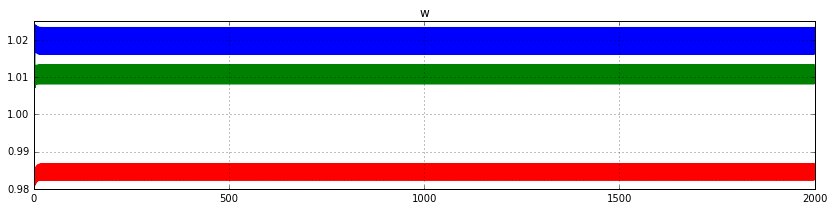

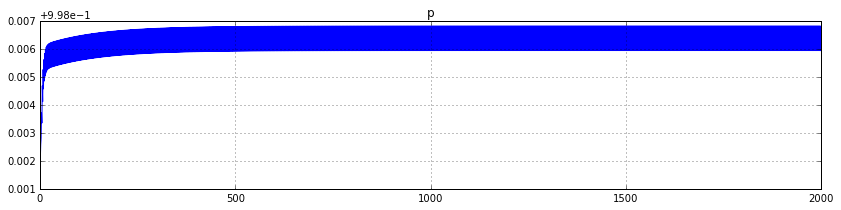

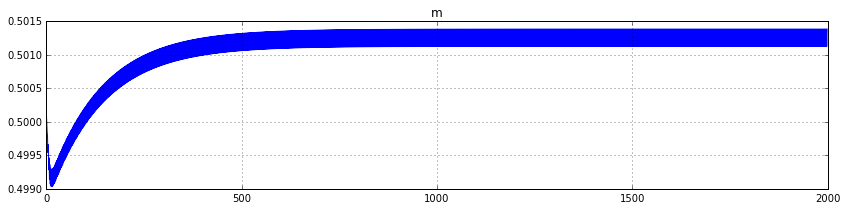

In [14]:
do_train(w_=w_value, p_=1, m_=mu_value + (sigma_value**2)/2, step_size_=0.01, training_steps = 2000)


The training algorithm at least did not spoil the correct parameter values.
#### Play with **w** and *m*

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  0.  0.]
    p = 1.0
    m = -0.5

Final model:
1999

    XPw = [ 3.30392456  2.51088761  9.06771365 ...,  1.65898692  8.06187155
  1.40411273]
    RT = [  4.94655188   4.15669912  10.67915999 ...,   3.30766262   9.67946792
   3.05349558]
    epsilon = [-0.89060531  4.94994935 -0.40814526 ...,  0.14572155  1.21169558
 -1.3244712 ]
    Ew_2 = 0.000280217906159
    MSE = 2.54358688329
    E = 2.5438671012
    gEw = [-0.07708603 -0.05687158 -0.04998251]
    gEp = 0.0895871119508
    gEm = -0.0262077775577
    w0 = [ 1.02159877  1.01113372  0.98387675]
    w1 = [ 1.02159877  1.01113372  0.98387675]
    w =  [ 1.02159877  1.01113372  0.98387675]
    p = 1.00105614248
    m = 0.501225827122



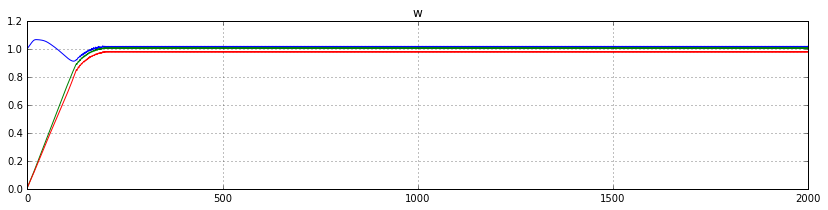

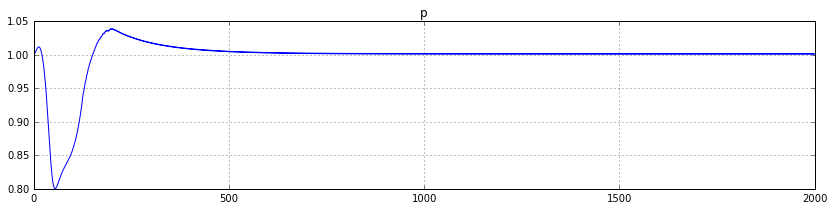

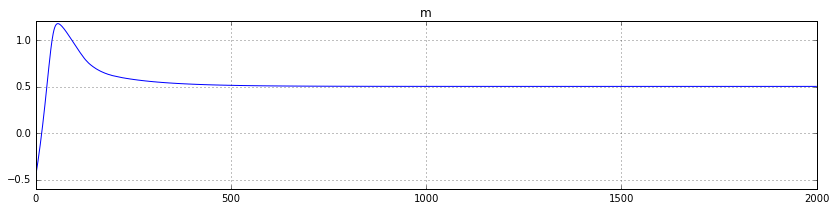

In [15]:
do_train(w_=np.array([1, 0, 0]), p_=1, m_=-0.5, step_size_=0.01, training_steps = 2000)

The correct values of **w** and *m* were discovered from the data.
#### Play with p while **w** and *m* are correct

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  1.  1.]
    p = 3.0
    m = 0.5

Final model:
1999

    XPw = [ 3.38897348  2.56801158  9.53170237 ...,  1.68613656  8.46814255
  1.4151475 ]
    RT = [  4.96123534   4.17350012  10.77052987 ...,   3.32161913   9.77204833
   3.05824416]
    epsilon = [-0.90528878  4.93314835 -0.49951513 ...,  0.13176504  1.11911517
 -1.32921979]
    Ew_2 = 0.00200785661682
    MSE = 2.54244730711
    E = 2.54445516373
    gEw = [ 0.15693305  0.0715333   0.05260977]
    gEp = -0.0767444731061
    gEm = 0.0231045174279
    w0 = [ 1.02583762  1.02027825  0.99969949]
    w1 = [ 1.02583762  1.02027825  0.99969949]
    w =  [ 1.02583762  1.02027825  0.99969949]
    p = 1.02085399815
    m = 0.502203215649



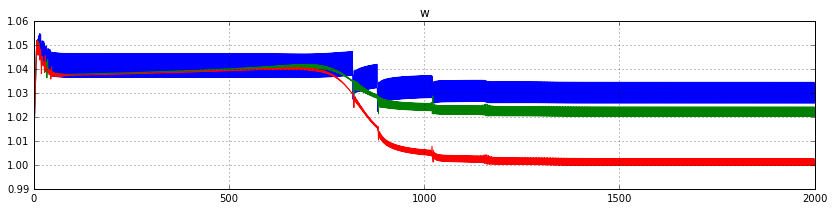

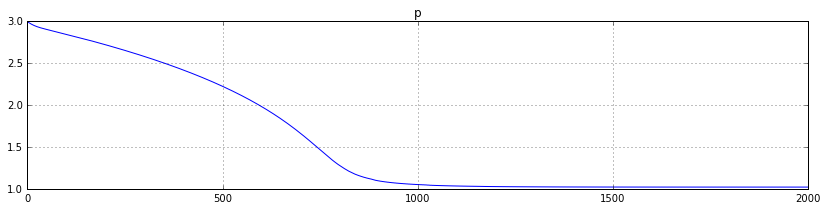

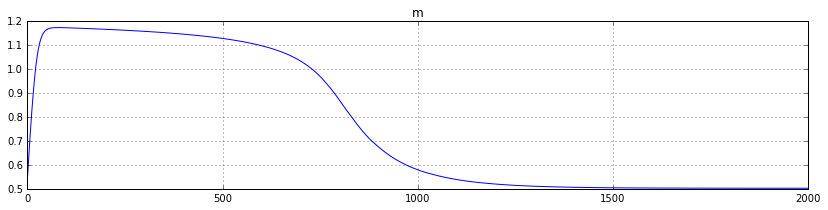

In [16]:
do_train(w_=w_value, p_=3, m_=mu_value + (sigma_value**2)/2, step_size_=0.01, training_steps = 2000)

The correct value of p was discovered from the data while **w** and *m* were preserved correct.

### Three partly sequential, partly concurrent transactions

Three transactions, their location param is 0, scale is 1, additive noise location 0, scale 1. The correct value of p is 3.

#### Generate the data

In [17]:
mu_value = 0.0
sigma_value = 1.0
p_value = 3
w_value = np.array([1, 1, 1]) # np.ones(n)/float(n)
X_samples, RT_samples = sample(locX=np.zeros(n), scaleX=np.ones(n), w=w_value, p=p_value, 
                               mu=mu_value, sigma=sigma_value, N=5000)

Generating 5000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 3,        mu = 0.0,        sigma = 1.0


#### Is the correct solution a fixpoint of the iteration?
Fit the model starting the iteration from the "correct" parameter values

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  1.  1.]
    p = 3.0
    m = 0.5

Final model:
1999

    XPw = [  0.91620015   5.44899436   0.17605182 ...,  18.314311     7.46791118
   2.17803424]
    RT = [ 2.69844492  3.47251537  2.29185919 ...,  4.32688702  3.6630304
  3.01830622]
    epsilon = [-1.1478728   0.14798152  2.64571518 ..., -0.19644258 -1.18826526
  0.85597622]
    Ew_2 = 6.1762360003e-06
    MSE = 2.32033989695
    E = 2.32034607318
    gEw = [-0.00163478 -0.00110872 -0.00099082]
    gEp = -0.00166311601463
    gEm = -0.00567294787539
    w0 = [ 0.97528687  0.98124973  0.94596633]
    w1 = [ 0.97528687  0.98124973  0.94596633]
    w =  [ 0.97528687  0.98124973  0.94596633]
    p = 3.04297056897
    m = 0.546324924808



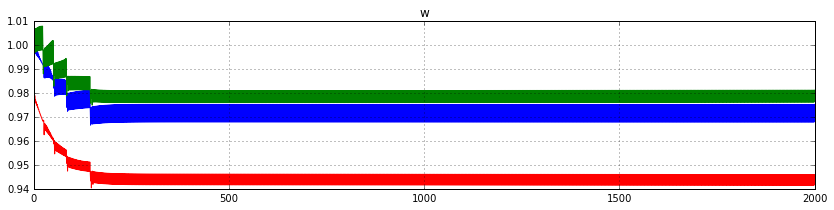

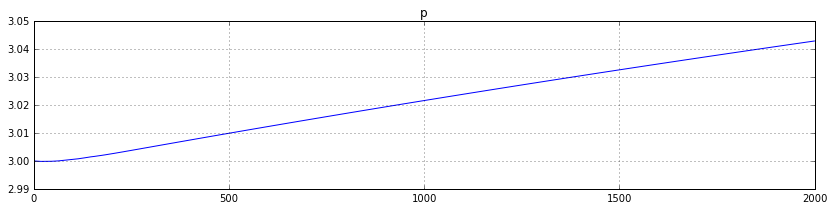

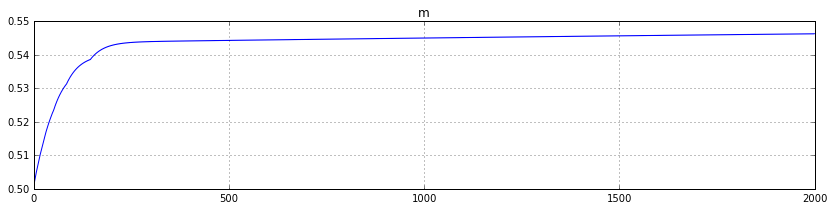

In [18]:
do_train(w_=w_value, p_=p_value, m_=mu_value + (sigma_value**2)/2, step_size_=0.01, training_steps = 2000)


The iteration is slowly drifting away from the correct values. (Maybe roundig errors or the noise in the data?)
#### Perturb **w** and *m*: do we return to the fixpoint?

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  0.  0.]
    p = 3.0
    m = -0.5

Final model:
1999

    XPw = [  0.90361514   6.19799912   0.14076071 ...,  22.68267823   8.37040171
   2.2628411 ]
    RT = [ 2.7258536   3.49578318  2.30765661 ...,  4.33526108  3.66189413
  3.03742093]
    epsilon = [-1.17528148  0.12471371  2.62991776 ..., -0.20481664 -1.18712899
  0.83686151]
    Ew_2 = 3.53438679041e-06
    MSE = 2.32018406401
    E = 2.3201875984
    gEw = [-0.00453786 -0.00280163 -0.0028199 ]
    gEp = 0.000503953051837
    gEm = -0.00518664446244
    w0 = [ 0.96739946  0.97624614  0.93837382]
    w1 = [ 0.96739946  0.97624614  0.93837382]
    w =  [ 0.96739946  0.97624614  0.93837382]
    p = 3.29474893
    m = 0.56317397403



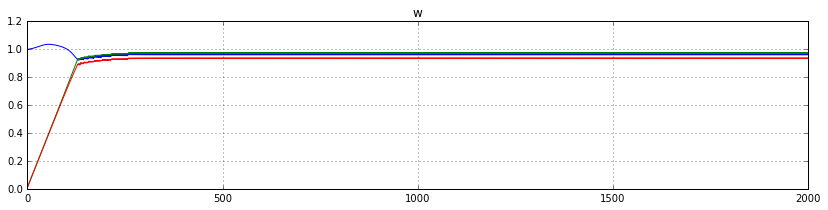

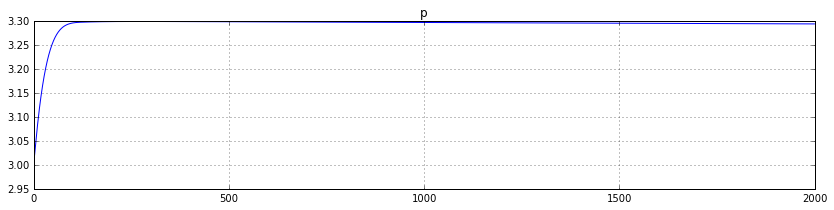

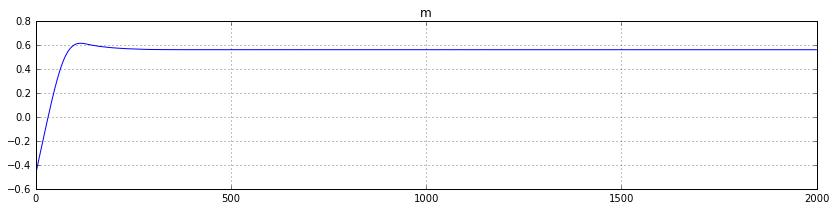

In [19]:
do_train(w_=np.array([1, 0, 0]), p_=p_value, m_=-0.5, step_size_=0.01, training_steps = 2000)


#### Perturb *p*

0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  1.  1.]
    p = 1.0
    m = 0.5

Final model:
1999

    XPw = [  0.92993081   3.90885699   0.30089295 ...,  10.71807382   5.51137115
   1.96567926]
    RT = [ 2.62658188  3.41431895  2.26449965 ...,  4.32528741  3.68297597
  2.97897117]
    epsilon = [-1.07600976  0.20617794  2.67307472 ..., -0.19484297 -1.20821083
  0.89531127]
    Ew_2 = 1.74197691195e-06
    MSE = 2.32561696538
    E = 2.32561870735
    gEw = [ 0.00099614  0.00058988  0.00081318]
    gEp = -0.0192913248974
    gEm = 0.00510807421111
    w0 = [ 0.95139373  0.95734688  0.92848884]
    w1 = [ 0.95139373  0.95734688  0.92848884]
    w =  [ 0.95139373  0.95734688  0.92848884]
    p = 2.41625153757
    m = 0.504475919663



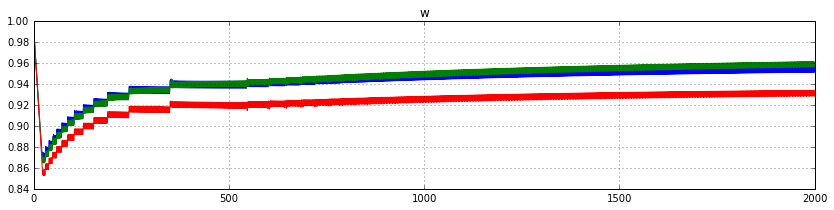

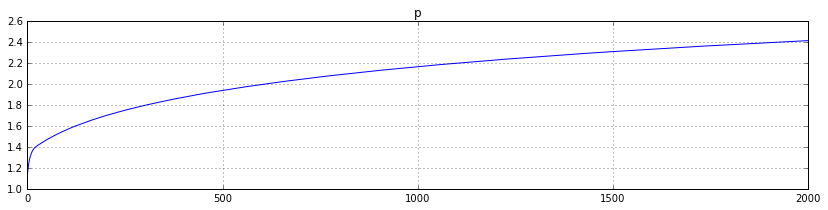

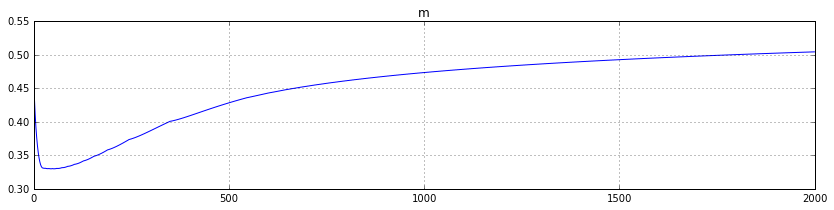

In [20]:
do_train(w_=w_value, p_=1, m_=mu_value + (sigma_value**2)/2, step_size_=0.01, training_steps = 2000)

#### Increase the size of the training set

Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 3,        mu = 0.0,        sigma = 1.0
0

    XPw = None
    RT = None
    epsilon = None
    Ew_2 = None
    MSE = None
    E = None
    gEw = None
    gEp = None
    gEm = None
    w0 = None
    w1 = None
    w =  [ 1.  1.  1.]
    p = 3.0
    m = 0.5

Final model:
1999

    XPw = [   0.87698531   84.8827144    22.98303253 ...,   39.67059811   29.46236957
  190.74691899]
    RT = [ 2.61568319  6.02963711  4.4907657  ...,  5.05375285  4.7343069
  7.37836974]
    epsilon = [-1.22656308  6.31872882  3.5781385  ..., -0.48223766 -1.29783468
 -1.16457039]
    Ew_2 = 0.00012127610107
    MSE = 2.27175545378
    E = 2.27187672988
    gEw = [ 0.00996383  0.00083322  0.00118745]
    gEp = -0.00077818453345
    gEm = 0.00366356819866
    w0 = [ 0.99738247  0.97143536  0.99262735]
    w1 = [ 0.99738247  0.97143536  0.99262735]
    w =  [ 0.99738247  0.97143536  0.99262735]
    p

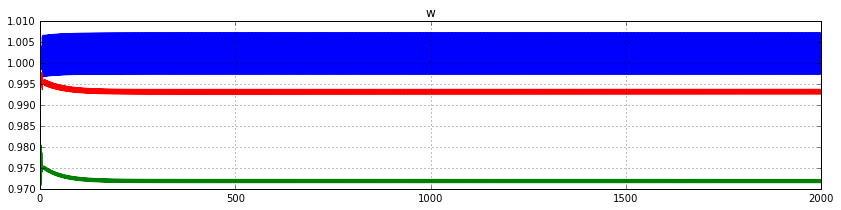

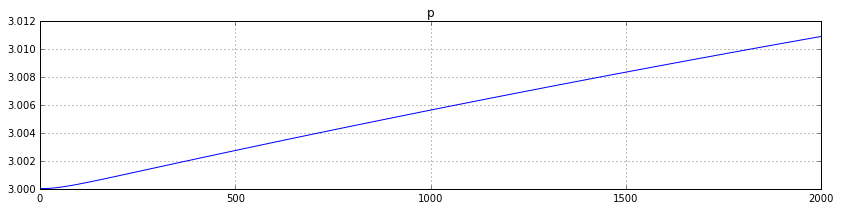

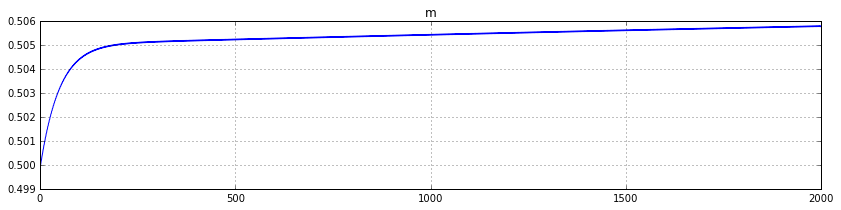

In [21]:
X_samples, RT_samples = sample(locX=np.zeros(n), scaleX=np.ones(n), w=w_value, p=p_value, 
                               mu=mu_value, sigma=sigma_value, N=50000)
do_train(w_=w_value, p_=p_value, m_=mu_value + (sigma_value**2)/2, step_size_=0.01, training_steps = 2000)

The correct solution is a fixpoint of the iteration.

## Analyse the mean squared error of perfectly fit models
The energy function penalises the difference between the predictions of the model and the training data.

In [22]:
Eof_p = theano.function(
          inputs=[X, y],
          outputs=[MSE, E],
)

In [23]:
print w_value, p_value, mu_value + (sigma_value**2)/2

[1 1 1] 3 0.5


### Dependence on *p*
We plot MSE as a function of p, for MSE calculated from different real_p_value.

In [24]:
def fillMSE(real_p_values, fro=0.4, to=10-0.1, N=200):
    MSE_results = list()
    E_results = list()
    labels = list()
    #print w_value, mu_value + (sigma_value**2)/2
    for real_p_value in real_p_values:
        label = "real_p_value={:5.2f}".format(real_p_value)
        labels.append(label)
        X_samples, RT_samples = sample(locX=np.zeros(n), scaleX=np.ones(n), w=w_value, p=real_p_value, 
                               mu=mu_value, sigma=sigma_value, N=50000)        
        MSE_values = list()
        E_values = list()
        w.set_value(w_value)     
        m.set_value(mu_value + (sigma_value**2)/2,)          
        for p_value in np.linspace(fro, to, N):
            p.set_value( p_value)
            MSE_values.append( (p_value, Eof_p(X_samples, RT_samples)[0]) )
            E_values.append(  (p_value, Eof_p(X_samples, RT_samples)[1]) )    
        E_results.append(E_values)
        MSE_results.append(MSE_values)
    return MSE_results, E_results, labels

In [25]:
def plotMSE(results, title, labels, fro=0, to=10):
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.title(title)
    plt.xlabel('p')
    plt.ylabel('MSE')
    #plt.yscale('log')
    colors = cm.rainbow(np.linspace(0, 1, len(results)))
    handles=list()
    for color, values in zip(colors, results):
        h = plt.plot(*zip(*values), linestyle='-', c=color, alpha=0.9)
        handles.append(h[0])
    plt.legend(handles, labels, loc='best')        
    #plt.scatter(*zip(*E_values), color='red', alpha=0.5)
    plt.xlim((fro, to))
    plt.ylim((2, 10))
    #plot(zip(*params)[i])
    plt.show()

.

In [30]:
real_p_values = sorted(np.concatenate([np.logspace(-.5, .5, 5), -np.logspace(-.5, .5, 3)]))

In [31]:
MSE_results, E_results, labels = fillMSE(real_p_values, fro=-9, to=9, N=400)

Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = -3.16227766017,        mu = 0.0,        sigma = 1.0
Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = -1.0,        mu = 0.0,        sigma = 1.0
Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = -0.316227766017,        mu = 0.0,        sigma = 1.0
Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 0.316227766017,        mu = 0.0,        sigma = 1.0
Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 0.56234132519,        mu = 0.0,        sigma = 1.0
Generating 50000 samples using the following parameters:
locX = [ 0.  0.  0.]        scaleX = 
w = [1 1 1],        p = 1.0,        mu = 0.0,        sigma =

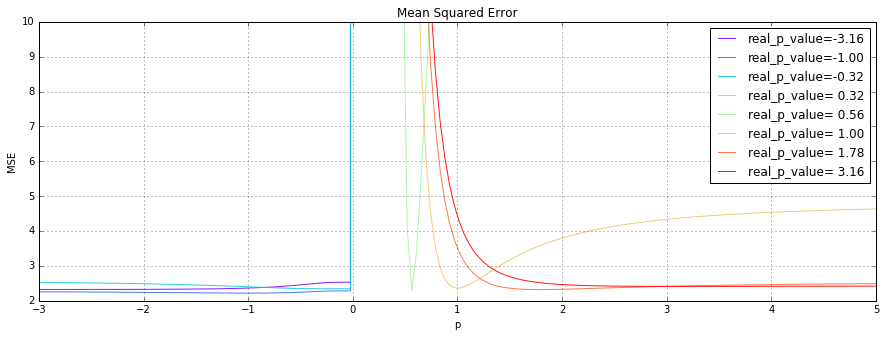

In [32]:
plotMSE(MSE_results, "Mean Squared Error", labels, fro=-3, to=5)

For $ real\_p\_value \le 0 $ the MSE is flat for any $p \lt 0$. If this is not a programing error, it means that at best we can infer that $ real\_p\_value \le 0 $ but have no chance to determine its concrete value. (As a remedy, we could try feeding $\frac{1}{X}$ into the model and taking $\frac{1}{RT}$ as its predictions. This should be equivalent to flipping the sign of $real\_p\_value$ up to the additive noise. (Does this noise dominate the MSE? What if we set it to a very low level?))

For $ real\_p\_value \gt 0 $ the gradient of $MSE$ is 0 at $ p = real\_p\_value $ on all of these plots. For $real\_p\_value > 2$ the energy function is quite flat in the domain $p \gt 2$. This suggests: 
- The predictions of the model depend weakly on the exact value of $real\_p\_value$ if $real\_p\_value \gt 2$.
- We have to expect that the values obtained for $p$ in this domain will be highly uncertain and regularization may be necessary.

Overall we can conclude that $p \gt 2$ indicates dominantly parallel execution of the children, with $p=\inf$ being perfect parallelism.

In [29]:
#theano.printing.pydotprint(gEm)